# Исследование воронки событий и результатов А/А/В-теста

## Содержание

### [Обзор данных](#overview)

### [Предобработка данных](#processing)

[Переименование колонок](#columns)

[Изменение типов данных](#data-type)

[Поиск дубликатов](#dublicates)

[Добавление колонки с датой события](#date-column)

### [Проверка качества данных](#data-check)

[События](#event-check)

[Пользователи](#user-check)

[Дата и время событий](#date-check)

[Экспериментальные группы](#group-check)

### [Изучение воронки событий](#funnel-research)

### [Изучение результатов эксперимента](#exp-research)

### [Общий вывод](#summary)

---

**Краткое описание:** Заказчик - стартап, продающий продукты питания. (1) Необходимо разобраться, как ведут себя пользователи вашего мобильного приложения. (2) Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры посчитали, что пользователям это может быть непривычно. Дизайнеры и менеджеры договорились провести A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.
    
**Цель проекта:** Изучить воронку продаж и результаты A/A/B-эксперимента.

**План работы:**
1. выгрузить данные, осуществить первичный обзор;
2. переименовать колонки, привести наименования к "змеиному регистру", если необходимо;
2. определить, есть ли пропуски в данных; заполнить пропуски или удалить строки с пропусками;
3. измененить тип данных;
4. проверить данные на наличие явных и неявных дубликатов, исправить данные;
5. добавить столбец даты и времени, отдельный столбец дат;
6. изучить и проверить данные;
7. изучить воронку событий;
8. изучить результаты эксперимента.

---

## Обзор данных
<a class='anchor' id='overview'></a>

In [1]:
# загружаем нужные библиотеки
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import math as mth
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [2]:
pth1 = 'logs_exp.csv' # Путь для Colaboratory
pth2 = '/datasets/logs_exp.csv' # Путь для Jupyter Notebook в Практикуме
pth3 = r'C:\Users\WANTNEON\Downloads\logs_exp.csv' # Локальный путь
    
if os.path.exists(pth1):
    data = pd.read_csv(pth1, sep='\t')
    print('Данные загружены в Colaboratory')
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, sep='\t')
    print('Данные загружены в Jupyter Notebook')
elif os.path.exists(pth3):
    data = pd.read_csv(pth3, sep='\t')
    print('Данные загружены локально')
else:
    print('Что-то пошло не так')  

Данные загружены в Colaboratory


Посмотрим на данные и их характеристики.

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
data.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

**Результаты первичного обзора данных**

* Все колонки не соответствуют требуемому стилю написания и не всегда отображают суть. Поменяем наименование колонок, чтобы было удобно и не забыть, что отображает каждая колонка;

* В данных нет пропусков;

* В колонке со временем события данные проедставлены в формате unix time. Необходимо перевести данную колонку в привычный вид даты и времени.

## Предобработка данных
<a class='anchor' id='processing'></a>

### Переименование колонок
<a class='anchor' id='columns'></a>

Переименуем колонки и проверим, все ли получилось.

In [6]:
data = data.rename(columns={
    'EventName' : 'event_name',
    'DeviceIDHash' : 'user_id',
    'EventTimestamp' : 'event_time',
    'ExpId' : 'exp_group'
    })

data.columns

Index(['event_name', 'user_id', 'event_time', 'exp_group'], dtype='object')

### Изменение типов данных
<a class='anchor' id='data-type'></a>

Поменяем тип данных колонки `'event_time'` на `datetime` и проверим, все ли получилось.

In [7]:
data['event_time'] = pd.to_datetime(data['event_time'], unit = 's')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   exp_group   244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


### Поиск дубликатов
<a class='anchor' id='dublicates'></a>

Проверим, есть ли в таблице строки-дубликаты и посчитаем их количество.

In [8]:
data.duplicated().sum()

413

Посмотрим, как выглядят дубликаты.

In [9]:
data.loc[data.duplicated(keep=False)].head(10)

,event_name,user_id,event_time,exp_group
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
4075,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4801,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248


In [10]:
print(
    'Процент дубликатов на удаление:',
    round(len(data.loc[data.duplicated()]) / len(data) * 100, 2),
    '%'
    )

Процент дубликатов на удаление: 0.17 %


Всего в датасете более 244 тыс. строк, поэтому удаление 413 никак не повлияет на дальнейших анализ.

In [11]:
data = data.drop_duplicates()

data.info() # посмотрим, сколько строк стало в датасете

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   exp_group   243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


### Добавление колонки с датой события
<a class='anchor' id='date-column'></a>

Добавим колонку с датой, преобразовав колонку с временем события, и посмотрим, как выглядит датасет с новой колонкой.

In [12]:
data['event_date'] = pd.to_datetime(data['event_time']).dt.normalize()

data.head()

,event_name,user_id,event_time,exp_group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Проверка качества данных
<a class='anchor' id='data-check'></a>

Мы сделали предобработку данных. Теперь посмотрим на их качество.

### События
<a class='anchor' id='event-check'></a>

In [13]:
# посмотрим, какие события есть в датасете

data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Всего 5 событий:
1. просмотр главной страницы;
2. просмотр страницы с товарами;
3. просмотр страницы с корзиной;
4. просмотр страницы с успешной оплатой;
5. просмотр страницы с инструкцией.

Конечно, главную страницу смотрят чаще всего. По количеству событий, можно предположить, что меньше половины пользователей с главной страницы переходят к товарам, а вот дальнейшая конверсия выглядит хорошо. Проверим это в анализе воронки.

### Пользователи
<a class='anchor' id='user-check'></a>

In [14]:
# посмотрим количество уникальных пользователей

data['user_id'].nunique()

7551

Выглядит так, что 7.5 тыс. пользователей очень активны и совершают огромное количество действий либо может оказаться наоборот, что из этих 7.5 лишь маленький процент очень продуктивен в совершении покупок.

In [15]:
# посчтитаем среднее и медианное количество событий для одного пользователя
# для этого сгруппируем данные по id пользователей и посчитаем количесво строк
# колонки со временем события, значения которой уникальны для пользователей

print(
    'Среднее количество событий на пользователя:',
    int(data.groupby('user_id').agg({'event_time' : 'count'}).mean())
)

print(
    'Медианное количество событий на пользователя:',
    int(data.groupby('user_id').agg({'event_time' : 'count'}).median())
)

Среднее количество событий на пользователя: 32
Медианное количество событий на пользователя: 20


Среднее количество больше медианного на 60% процентов, поэтому есть большая вероятность того, что вторая теория (большинство пользователей не активно в совершении действий) может подтвердиться. Проверим это, построив гистограмму.

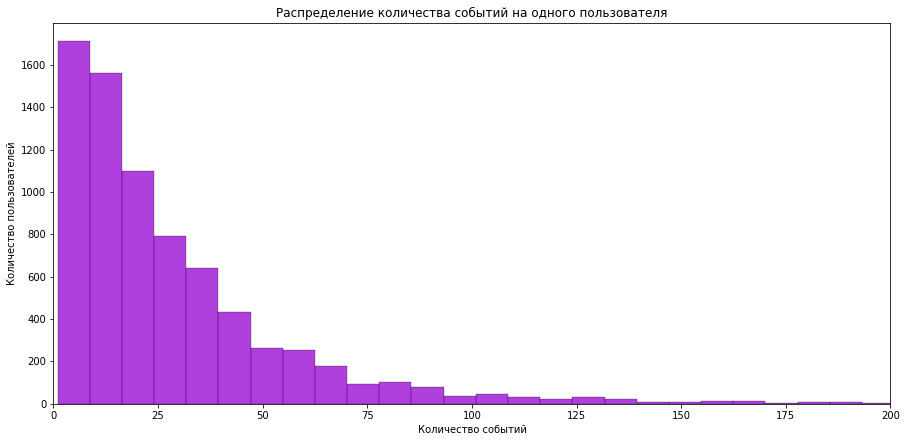

In [16]:
plt.figure(figsize=(15, 7))

sns.histplot(
    data=data.groupby('user_id').agg({'event_time' : 'count'})['event_time'],
    bins=300, color='#9400D3')

plt.title('Распределение количества событий на одного пользователя')
plt.xlabel('Количество событий')
plt.xlim(0, 200)
plt.ylabel('Количество пользователей')

plt.show()

Предположение подтвердилось: большинство пользователей, а именно 1700, за время проведения эксперимента совершило до 8 событий.

### Дата и время событий
<a class='anchor' id='date-check'></a>

In [17]:
# посмотрим период, за который предоставлены данные
# найдем максимальное и минимальное значения колонки с датами событий

print('Начало периода:', min(data['event_date']))

print('Конец периода:', max(data['event_date']))

Начало периода: 2019-07-25 00:00:00
Конец периода: 2019-08-07 00:00:00


Мы имеем данные с 25.07.2019 по 07.08.2019. Посмотрим, как они распределены, с помощью графика.

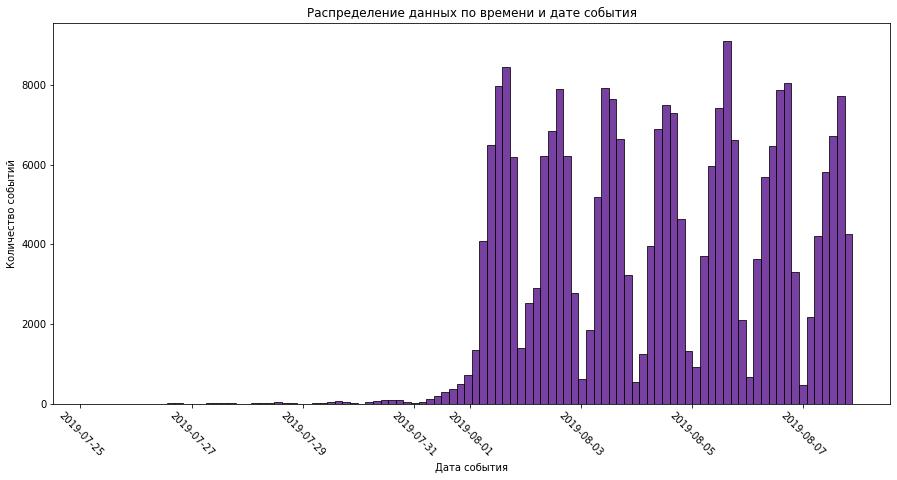

In [18]:
plt.figure(figsize=(15, 7))

sns.histplot(data=data['event_time'], bins=100, color='#4B0082')

plt.title('Распределение данных по времени и дате события')
plt.xlabel('Дата события')
plt.xticks(rotation=-45)
plt.ylabel('Количество событий')

plt.show()

Данные распределены неравномерно. Определенно, до 01.08.2019 данные неполные. Придется их удалить.

In [19]:
# посмотрим, сколько данных нужно удалить

print('Всего строк / событий в таблице:', len(data))

print(
    'Количество строк / событий на удаление:',
    len(data.loc[data['event_date'] < '2019-08-01'])
    )

print(
    'Процент строк / событий на удаление:',
    round(
        len(data.loc[data['event_date'] < '2019-08-01']) /
        len(data) * 100, 2
        ), '%'
    )

print()

print('Всего пользователей в таблице:', data['user_id'].nunique())

print(
    'Количество пользователей на удаление:',
    data.query('event_date < "2019-08-01"')['user_id'].nunique()
    )

print(
    'Процент пользователей на удаление:',
    round(
        data.query('event_date < "2019-08-01"')['user_id'].nunique() /
        data['user_id'].nunique() * 100, 2
        ), '%'
    )

Всего строк / событий в таблице: 243713
Количество строк / событий на удаление: 2826
Процент строк / событий на удаление: 1.16 %

Всего пользователей в таблице: 7551
Количество пользователей на удаление: 1451
Процент пользователей на удаление: 19.22 %


In [20]:
# удаляем лишние строки

data = data.loc[data['event_date'] >= '2019-08-01']

# проверим, все ли получилось

data['event_date'].value_counts()

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
Name: event_date, dtype: int64

In [21]:
# посмотрим, сколько пользователей осталось

print(
    'Количество уникальных пользователей в новом датасете:',
    data['user_id'].nunique()
    )

Количество уникальных пользователей в новом датасете: 7534


Мы удалили 1.16% строк, что очень мало. Также мы полность удалили данные о 17 пользователях, или 0.23% от всех пользователей.

В итоге у нас остались данные за период 01-07.08.2019: неделя с равномерным ежедневным распределением данных.

### Экспериментальные группы
<a class='anchor' id='group-check'></a>

In [22]:
# проверим, есть ли в датасете три экспериментальные группы

data['exp_group'].value_counts()

248    84563
246    79302
247    77022
Name: exp_group, dtype: int64

В датасете присутствуют три группы пользователей: 246 и 247 — контрольные группы, 248 — экспериментальная. Лишних групп нет.

Проверим, не попали ли пользователи в разные группы. Для этого сгруппируем данные по группам, найдем количество уникальных пользователей для каждой из них и найдем сумму полученных значений. если она совпадет с количество уникальных пользователей во всей таблице, то трафик был разделен успешно.

In [23]:
print('Всего пользователей в таблице:', data['user_id'].nunique())

print(
    'Сумма уникальных пользователей экспериментальных групп:',
    data.groupby('exp_group').agg({'user_id' : 'nunique'})['user_id'].sum()
)

Всего пользователей в таблице: 7534
Сумма уникальных пользователей экспериментальных групп: 7534


Отличная работа команды! Ни один пользователь не попал в несколько групп.

Данные подготовлены, можно приступать к исследовательскому анализу.

## Изучение воронки событий
<a class='anchor' id='funnel-research'></a>

Прежде чем начать изучат воронку, посмотрим на события еще раз.

In [24]:
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Напомним, что всего 5 событий (в порядке убывания популярности):
1. просмотр главной страницы;
2. просмотр страницы с товарами;
3. просмотр страницы с корзиной;
4. просмотр страницы с успешной оплатой;
5. просмотр страницы с инструкцией.

Посмотрим, какое количество пользователей и какая их доля совершает каждое действие. Для этого сгруппируем данные по событиям и посчитаем количество уникальных пользователей для них, построим графики.

In [25]:
event_user = (
    data.groupby('event_name')
    .agg({'user_id' : 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)

# добавляем общее количество пользователей для каждой группы в начало таблицы

event_user.loc[-1] = ['UsersCount', data['user_id'].nunique()]
event_user.index = event_user.index + 1
event_user = event_user.sort_index()

# добавляем колонку с процентом пользователей, совершивших действия
# от общего количества пользователей, участвовавших в эксперименте

event_user['percent'] = round(
    event_user['user_id'] / data['user_id'].nunique() * 100, 2
    )

event_user

,event_name,user_id,percent
0,UsersCount,7534,100.00
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
3,CartScreenAppear,3734,49.56
4,PaymentScreenSuccessful,3539,46.97
5,Tutorial,840,11.15


In [26]:
colors = ['#4B0082', '#8B008B', '#9932CC', '#9400D3', '#8A2BE2', '#483D8B']

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=(
                        'Количество пользователей, совершивших событие',
                        'Процент пользователей, совершивших событие'
                        ),
                    specs=[[{'type': 'xy'}, {'type': 'xy'}]])

fig.add_trace(
    go.Bar(y=event_user['user_id'], x=event_user['event_name'],
           marker_color=colors),
           row=1, col=1
)

fig.add_trace(
    go.Bar(y=event_user['percent'], x=event_user['event_name'],
           marker_color=colors),
           row=1, col=2
)

fig.update_layout(showlegend=False)

fig.show()

**Вывод**

Самое популярное событие, как ни странно, - это посещение главной страницы. Это событие совершили 98% пользователей, или 7419 пользователей из 7551 пользователя, участвовавших в эксперименте.

Страницу с товарами просматривал 61% пользователей, корзину смотрели почти 50%, страницу с успешной оплатой увидели 47% пользователей. Инструкцию посмотрело 11%.

Вероятнее всего события происходят примерно в таком порядке. Это видно и по уменьшению процента пользователей, переходящих к следующей странице. Исключение - просмотр инструкции: ее можно посмотреть на любом из указанных этапов, когда у пользователя возникли вопросы.

Исключим строки с событием "просмотр инструкции" из датасета, т.к. он будет мешать анализу.

In [27]:
# посмотрим, сколько данных нужно удалить

print(
    'Количество строк на удаление:',
    len(data.loc[data['event_name'] == 'Tutorial'])
    )

print(
    'Процент строк на удаление:',
    round(
        len(data.loc[data['event_name'] == 'Tutorial']) /
        len(data) * 100, 2
        ), '%'
    )

Количество строк на удаление: 1005
Процент строк на удаление: 0.42 %


In [28]:
# удаляем лишние строки

data = data.loc[data['event_name'] != 'Tutorial']
event_user = event_user[event_user['event_name'] != 'Tutorial']

Добавим в группированную по событиям таблицу долю пользователей, которая проходит на следующий шаг воронки (от числа пользователей на предыдущем).

Построим воронку, в которой отобразим количество пользователей для каждого шага и долю пользователей, которая проходит на следующий шаг воронки.

In [29]:
event_user['prev_percent'] = round(
    event_user['user_id'] / event_user['user_id'].shift(1) * 100,
    2).fillna(100)

event_user

,event_name,user_id,percent,prev_percent
0,UsersCount,7534,100.00,100.00
1,MainScreenAppear,7419,98.47,98.47
2,OffersScreenAppear,4593,60.96,61.91
3,CartScreenAppear,3734,49.56,81.30
4,PaymentScreenSuccessful,3539,46.97,94.78


In [30]:
fig = go.Figure(go.Funnel(
    y = event_user['event_name'],
    x = event_user['user_id'],
    textinfo = 'value+percent previous',
    marker = {'color': '#8A2BE2'}))

fig.show()

**Вывод**

2% пользователей, зайдя в приложение, не попадают на главную страницу. Возможно, у приложения были ошибки при открытии, либо пользователи через push-уведомление попадали сразу на нужную страницу.

36% пользователей не переходит с главной страницы на страницу с товарами. Это может быть связано с техническими проблемами (кнопка не всегда кликабельна, событие не всегда фиксируется и т.п.) или главная страница не привлекает пользователей. Также можно посмотреть, с каких каналов привлечения пришли пользователи, чтобы не использовать каналы с малой конверсией пользователей на данном шаге в дальнейшем.

Далее картина выглядит приятно: 81% пользователей, посмотрев товары, переходит в корзину, а 95% из них успешно оплачивает товар.

От первого события до оплаты доходит 47% пользователей.

## Изучение результатов эксперимента
<a class='anchor' id='exp-research'></a>

Для начала посчитаем, количество уникальных пользователей для каждой экспериментальной группы.

In [31]:
group_user = data.pivot_table(
    columns='exp_group',
    values='user_id',
    aggfunc='nunique'
    )

group_user

exp_group,246,247,248
user_id,2483,2512,2535


В каждой группе примерно одникаковое количество пользователей.

Создадим сводную таблицу, в которой будет определено уникальное количество пользователей для каждой экспериментальной группы и для каждого события.

In [32]:
group_stat = (
    data.pivot_table(
        index='event_name',
        columns='exp_group',
        values='user_id',
        aggfunc='nunique'
        )
    .sort_values(by=246, ascending=False)
    .reset_index()
    .rename_axis(None, axis=1)
)

# добавляем общее количество пользователей для каждой группы в начало таблицы

group_stat.loc[-1] = group_user.loc['user_id']
group_stat.index = group_stat.index + 1
group_stat = group_stat.sort_index()
group_stat['event_name'] = group_stat['event_name'].fillna('UsersCount')
group_stat = group_stat.set_index('event_name')

# корректируем тип данных

group_stat[[246, 247, 248]] = group_stat[[246, 247, 248]].astype(int)

Построим воронку, в которой отобразим для каждой группы количество пользователей в каждом шаге и долю пользователей, которая проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [33]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Все группы',
    y = event_user['event_name'],
    x = event_user['user_id'],
    textinfo = 'value+percent previous',
    marker = {'color': '#483D8B'}))

fig.add_trace(go.Funnel(
    name = 'Группа 246',
    y = group_stat.index,
    x = group_stat[246],
    textinfo = 'value+percent previous',
    marker = {'color': '#8A2BE2'}))

fig.add_trace(go.Funnel(
    name = 'Группа 247',
    y = group_stat.index,
    x = group_stat[247],
    textinfo = 'value+percent previous',
    marker = {'color': '#8B008B'}))

fig.add_trace(go.Funnel(
    name = 'Группа 248',
    y = group_stat.index,
    x = group_stat[248],
    textinfo = 'value+percent previous',
    marker = {'color': '#4B0082'}))

fig.show()

**Вывод**

У группы с измененным шрифтом № 248:
  
* конверсия перехода на главную страницу ниже, чем у контрольных групп на 0.4-0.5%;


* конверсия перехода с главной страницы на страницу с предложением товаров такая же, как у контрольной группы № 247, но ниже конверсии группы № 246 на 1.5%;


* конверсия перехода из просмотра товара в корзину наже, чем у контрольных групп на 1.1-1.8%;


* конверсия перехода из корзины в успешную оплату выше, чем у контрольных групп на 1.2-2.5%.
    
Иными словами, процент пользователей, перешедших на следующий шаг, между группами отличается на 1-2 процента.
    
Процент перехода на страницу с успешной оплатой у группы с другим шрифтом немного больше, а процент перехода на просмотр корзины меньше, чем у других групп.

Проверим статистическую значимость между группами, чтобы понять, является ли эти процент-два значительным отличием или нет.

In [34]:
# создадим функцию, которая будет рассчитывать статистическую значимость
# различий в пропорциях при указанных размерах выборок

def events_stat(user_count, group_number_1, group_number_2, event_name, alpha):

    # определяем массив для выборок
    trials = np.array(
        [group_stat.loc[user_count, group_number_1],
        group_stat.loc[user_count, group_number_2]]
        )
    
    # определяем массив для событий
    successes = np.array(
        [group_stat.loc[event_name, group_number_1],
        group_stat.loc[event_name, group_number_2]]
        )

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1])
        )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', round(p_value, 4))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

Данные и функция подготовлены.

Если бы пропорции были равны, разница между ними была бы равна нулю. Посчитаем, как далеко статистика уехала от нуля. Сформируем гипотезы и применим функцию.

*Примечание: Чтобы найти баланс между мощностью и значимостью, применем значимость равнойю 0.05, поскольку выборки получились примерно по 2.5 тысячи, но доли этих выборок для событий еще меньше. Это не та ситуация, когда при выборках большого объема случайные отклонения компенсируют друг друга, и получить значимое различие в выборках при их однородности менее вероятно.*

*Таким образом, при данной значимости существует 5%-ная вероятность того, что результат является случайным.*

*Поскольку мы будем сравнивать выборки не только по трем группам, а также с объединенной контрольной группой и подгруппами в виде четрыех действий пользователей, то получается 16 нулевых и альтернативных гипотез. В данном случае применение поправки на множественную проверку гипотез очень сильно уменьшит мощность, что не следует делать для небольшой выборки.*

Н0: нет различий в конверсии из перехода в приложение в просмотр главной страницы между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр главной страницы между выборками.

In [35]:
events_stat('UsersCount', 246, 247, 'MainScreenAppear', 0.01)

p-значение:  0.7527
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр товаров между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр товаров между выборками.

In [36]:
events_stat('UsersCount', 246, 247, 'OffersScreenAppear', 0.01)

p-значение:  0.2479
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр корзины между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр корзины между выборками.

In [37]:
events_stat('UsersCount', 246, 247, 'CartScreenAppear', 0.01)

p-значение:  0.2287
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр страницы удачной оплаты между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр страницы удачной оплаты между выборками.

In [38]:
events_stat('UsersCount', 246, 247, 'PaymentScreenSuccessful', 0.01)

p-значение:  0.1145
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**

Нулевые гипотезы о различии между контрольными группами подтвердить не удалось, что говорит о том, что:

* различия между ними не являются статистически значимыми,

* все механизмы проведения эксперимента должны быть корректными.

Проверим статистическую значимость различий между контрольной группой № 246 и группой с измененным шрифтом № 248.

Н0: нет различий в конверсии из перехода в приложение в просмотр главной страницы между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр главной страницы между выборками.

In [39]:
events_stat('UsersCount', 246, 248, 'MainScreenAppear', 0.01)

p-значение:  0.3387
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр товаров между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр товаров между выборками.

In [40]:
events_stat('UsersCount', 246, 248, 'OffersScreenAppear', 0.01)

p-значение:  0.2144
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр корзины между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр корзины между выборками.

In [41]:
events_stat('UsersCount', 246, 248, 'CartScreenAppear', 0.01)

p-значение:  0.0807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр страницы удачной оплаты между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр страницы удачной оплаты между выборками.

In [42]:
events_stat('UsersCount', 246, 248, 'PaymentScreenSuccessful', 0.01)

p-значение:  0.2169
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**

Нулевые гипотезы о различии между контрольной группой № 246 и группой с измененным шрифтом № 248 подтвердить не удалось, что говорит о том, что:

* различия между ними не являются статистически значимыми,

* измененный шрифт не влияет на доли пользователей, посетивших страницы приложения.

Проверим статистическую значимость различий между контрольной группой № 247 и группой с измененным шрифтом № 248.

Н0: нет различий в конверсии из перехода в приложение в просмотр главной страницы между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр главной страницы между выборками.

In [43]:
events_stat('UsersCount', 247, 248, 'MainScreenAppear', 0.01)

p-значение:  0.5195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр товаров между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр товаров между выборками.

In [44]:
events_stat('UsersCount', 247, 248, 'OffersScreenAppear', 0.01)

p-значение:  0.9334
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр корзины между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр корзины между выборками.

In [45]:
events_stat('UsersCount', 247, 248, 'CartScreenAppear', 0.01)

p-значение:  0.5878
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр страницы удачной оплаты между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр страницы удачной оплаты между выборками.

In [46]:
events_stat('UsersCount', 247, 248, 'PaymentScreenSuccessful', 0.01)

p-значение:  0.7276
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**

Нулевые гипотезы о различии между контрольной группой № 247 и группой с измененным шрифтом № 248 подтвердить не удалось, что говорит о том, что:

* различия между ними не являются статистически значимыми,

* измененный шрифт не влияет на доли пользователей, посетивших страницы приложения.

Теперь проверим статистическую значимость различий между объединенными контрольными группами и группой с измененным шрифтом № 248.

Добавим соответствующую колонку в group_stat, проверим гипотезы.

In [47]:
group_stat['control_sum'] = group_stat[246] + group_stat[247]

Н0: нет различий в конверсии из перехода в приложение в просмотр главной страницы между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр главной страницы между выборками.

In [48]:
events_stat('UsersCount', 'control_sum', 248, 'MainScreenAppear', 0.01)

p-значение:  0.3487
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр товаров между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр товаров между выборками.

In [49]:
events_stat('UsersCount', 'control_sum', 248, 'OffersScreenAppear', 0.01)

p-значение:  0.4458
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр корзины между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр корзины между выборками.

In [50]:
events_stat('UsersCount', 'control_sum', 248, 'CartScreenAppear', 0.01)

p-значение:  0.1868
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0: нет различий в конверсии из перехода в приложение в просмотр страницы удачной оплаты между выборками.

Н1: есть различия в конверсии из перехода в приложение в просмотр страницы удачной оплаты между выборками.

In [51]:
events_stat('UsersCount', 'control_sum', 248, 'PaymentScreenSuccessful', 0.01)

p-значение:  0.6108
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**

Нулевые гипотезы о различии между объединенными контрольными группами и группой с измененным шрифтом № 248 подтвердить не удалось, что говорит о том, что:

* различия между ними не являются статистически значимыми,

* измененный шрифт не влияет на доли пользователей, посетивших страницы приложения.

## Общий вывод
<a class='anchor' id='summary'></a>

1. Самое популярное событие - это посещение главной страницы. Это событие совершили 98% пользователей, или 7419 пользователей из 7551 пользователя, участвовавших в эксперименте.

  Страницу с товарами просматривал 61% пользователей.
  
  Корзину смотрели 50% пользователей.
  
  Страницу с успешной оплатой увидели 47% пользователей.
  
  Инструкцию посмотрело 11%.
  
---

2. 2% пользователей, зайдя в приложение, не попадают на главную страницу. 

  62% пользователей переходит с главной страницы на страницу с товарами. 
  
  81% пользователей, посмотрев товары, переходит в корзину.
  
  95% из корзины переходят к успешной оплате товара.
  
  От входа в приложение до оплаты доходит 47% пользователей.
  
---

3. На главную страницу перешло 98.7% пользователей в контрольной группе № 246, 98.6% в контрольной группе № 247 и 98.3% в группе с другим шрифтом № 248.

  С главной страницы на страницу с предложением товаров перешло 62.9% в группе № 246, 61.4% в группе № 247 и 61.4% в группе № 248.

  После просмотра товара в корзину перешло 82.1% в группе № 246, 81.4% в группе № 247 и 80.3% в группе № 248.

  Успешно оплатило товар 94.8% пользователей в группе № 246, 93.5% в группе № 247 и 96% в группе № 248.

  Таким образом, у группы с измененным шрифтом № 248:
  
* конверсия перехода на главную страницу ниже, чем у контрольных групп на 0.4-0.5%;


* конверсия перехода с главной страницы на страницу с предложением товаров такая же, как у контрольной группы № 247, но ниже конверсии группы № 246 на 1.5%;


* конверсия перехода из просмотра товара в корзину наже, чем у контрольных групп на 1.1-1.8%;


* конверсия перехода из корзины в успешную оплату выше, чем у контрольных групп на 1.2-2.5%.


    
    Однако, проверка статистической значимости различий выборок показала, что различия между ними не являются статистически значимыми.
  
---

В итоге, опредилить лучший шрифт для приложения не удалось, т.е. измененный шрифт не влияет на доли пользователей, посетивших страницы приложения.

